# Routes annotation with clustering

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

%matplotlib inline

from collections import defaultdict
from scipy.stats import kurtosis, skew
from ml.utils import create_dataset_dicts, plot_routes

Extract images from dataset

In [3]:
dataset_dicts = create_dataset_dicts("../data/bh/test")
d_dict = dataset_dicts[1]
image_bgr = cv2.imread(d_dict["file_name"])
image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
# image = image_bgr

# Color Moments

In [4]:
# Masked versions of color moments https://en.wikipedia.org/wiki/Color_moments
def masked_skewness(image, mask):
    np_image = np.transpose(image, (2, 0, 1)).astype("float64")
    mask_3 = np.array([mask, mask, mask])
    np_mask = np.ma.make_mask(mask_3)
    np_image = np.ma.array(np_image, mask=np_mask)
    image_raveled = np.ma.reshape(np_image, (3, -1))
    return skew(image_raveled, axis=1)


def masked_kurtosis(image, mask):
    np_image = np.transpose(image, (2, 0, 1)).astype("float64")
    mask_3 = np.array([mask, mask, mask])
    np_mask = np.ma.make_mask(mask_3)
    np_image = np.ma.array(np_image, mask=np_mask)
    image_raveled = np.ma.reshape(np_image, (3, -1))
    return kurtosis(image_raveled, axis=1)

In [5]:
color_moments = defaultdict(list)
for idx, poly in enumerate(d_dict["annotations"]):
    if poly["category_id"] == 1:
        # Volumes are considered part of the wall, not part of a route -> skip
        continue
    points = np.array(poly["segmentation"])
    points = points.reshape((-1, 2)).astype(np.int32)
    points = points[np.newaxis, :]
    mask = cv2.fillPoly(np.zeros(image.shape[:2]), points, 255).astype(np.uint8)
    mean_v, std_v = cv2.meanStdDev(image, mask=mask)
    # skew_v = masked_skewness(image, mask)
    # kurtosis_v = masked_kurtosis(image, mask)
    color_moments[idx].extend(mean_v[0:1, 0])
    color_moments[idx].extend(std_v[0:1, 0])
    # color_moments[idx].extend(skew_v[0:3])
    # color_moments[idx].extend(kurtosis_v[0:3])

In [6]:
color_moment_arr = np.array(list(color_moments.values()))
color_moments_arr_norm = color_moment_arr - np.mean(color_moment_arr, axis=0)
color_moments_arr_norm = color_moments_arr_norm / np.std(color_moments_arr_norm, axis=0)

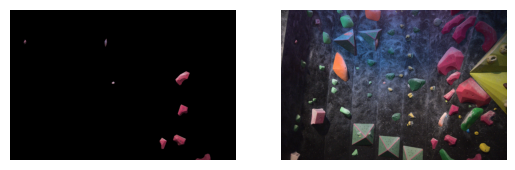

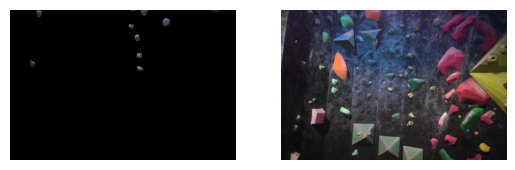

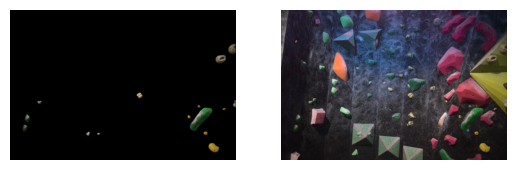

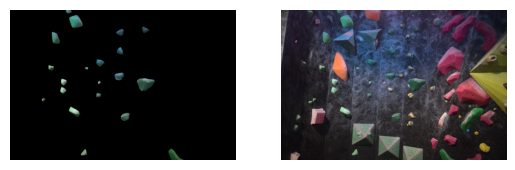

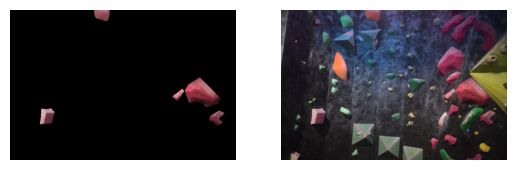

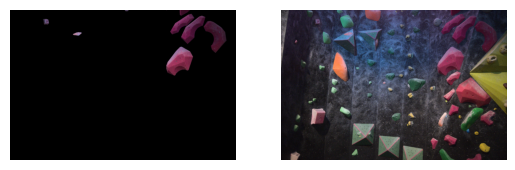

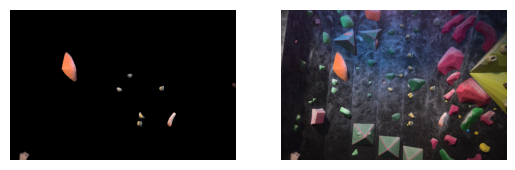

In [7]:
clustering_input = color_moments_arr_norm  # color_moment_arr
km_moments = KMeans(n_clusters=7, random_state=42, n_init="auto")

km_moments.fit_predict(clustering_input)

routes = defaultdict(list)
for id, cluster in zip(range(clustering_input.shape[0]), km_moments.labels_):
    routes[cluster].append(id)

figures_axes = plot_routes(routes, d_dict)
for (fig, ax) in figures_axes:
    fig.canvas.draw()

# Histogram

In [8]:
histograms = defaultdict(list)
for idx, poly in enumerate(d_dict["annotations"]):
    if poly["category_id"] == 1:
        # Volumes are considered part of the wall, not part of a route -> skip
        continue
    points = np.array(poly["segmentation"])
    points = points.reshape((-1, 2)).astype(np.int32)
    points = points[np.newaxis, :]
    mask = cv2.fillPoly(np.zeros(image.shape[:2]), points, 255).astype(np.uint8)
    hist0 = cv2.calcHist([image], [0], mask=mask, histSize=[256], ranges=[0, 256])
    hist1 = cv2.calcHist([image], [1], mask=mask, histSize=[256], ranges=[0, 256])
    hist2 = cv2.calcHist([image], [2], mask=mask, histSize=[256], ranges=[0, 256])
    hist = np.array([hist0])
    histograms[idx] = hist.flatten()

In [9]:
histograms_arr = np.array(list(histograms.values()))
histograms_arr_norm = histograms_arr - np.mean(histograms_arr, axis=0)
histograms_arr_norm = np.nan_to_num(
    histograms_arr_norm / np.std(histograms_arr_norm, axis=0)
)

/tmp/ipykernel_53684/3847019882.py:4: RuntimeWarning: invalid value encountered in divide
  histograms_arr_norm / np.std(histograms_arr_norm, axis=0)


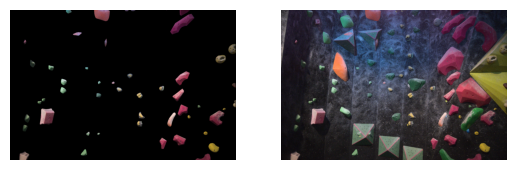

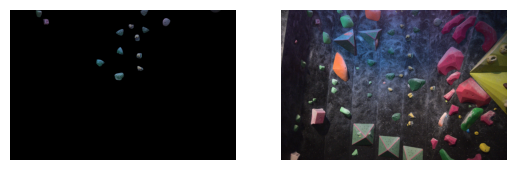

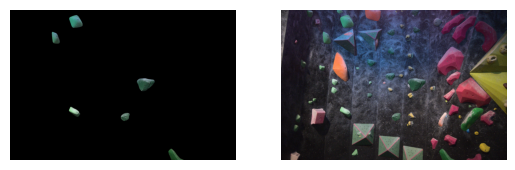

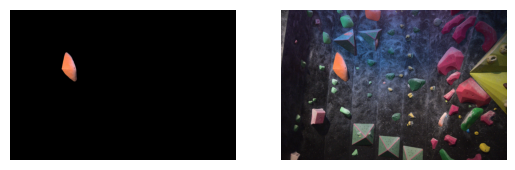

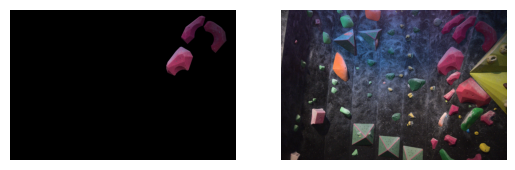

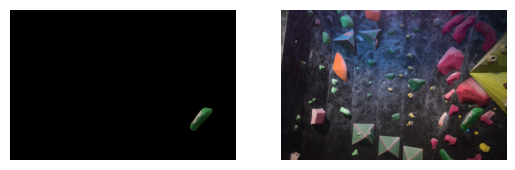

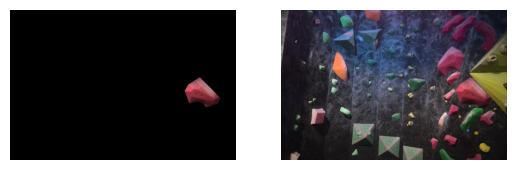

In [10]:
clustering_input = histograms_arr_norm  # histograms_arr
km_histogram = KMeans(n_clusters=7, random_state=42, n_init="auto")

km_histogram.fit_predict(clustering_input)

routes = defaultdict(list)
for id, cluster in zip(range(clustering_input.shape[0]), km_histogram.labels_):
    routes[cluster].append(id)

figures_axes = plot_routes(routes, d_dict)
for (fig, ax) in figures_axes:
    fig.canvas.draw()